<a href="https://colab.research.google.com/github/GraciousWeb/credit-risk-fraud-detection/blob/main/fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

In [ ]:
df = pd.read_csv('fraudTrain.csv')
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [ ]:
#extract the hour of transaction from the transaction date and time
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['hour'] = df['trans_date_trans_time'].dt.hour

In [ ]:
#calculate the age of customer
df['dob'] = pd.to_datetime(df['dob'])
df['age'] = df['trans_date_trans_time'].dt.year - df['dob'].dt.year

In [ ]:
#calculate the distance between merchant and customer using the haversine formula
import numpy as np

def haversine_distance(lat1, lon1, lat2, lon2):
    #radius of the Earth in miles
    r = 3958.8

    #convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    #differences
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    #haversine formula math
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return c * r

#create the 'distance' column
df['distance'] = haversine_distance(df['lat'], df['long'], df['merch_lat'], df['merch_long'])

In [ ]:
columns_to_drop = ['Unnamed: 0', 'trans_num', 'cc_num', 'first', 'last', 'unix_time', 'street', 'zip', 'city',
                   'state', 'lat', 'long', 'dob', 'trans_date_trans_time', 'merch_lat', 'merch_long']
df.drop(columns=columns_to_drop, inplace=True)
df.head()

,merchant,category,amt,gender,city_pop,job,is_fraud,hour,age,distance
0,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,3495,"Psychologist, counselling",0,0,31,48.838809
1,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,149,Special educational needs teacher,0,0,41,18.773185
2,fraud_Lind-Buckridge,entertainment,220.11,M,4154,Nature conservation officer,0,0,57,67.236892
3,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,1939,Patent attorney,0,0,52,59.449252
4,fraud_Keeling-Crist,misc_pos,41.96,M,99,Dance movement psychotherapist,0,0,33,48.192064


In [ ]:
df = df.dropna(subset=['is_fraud'])

In [ ]:
#split between training and val sets
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
#stratify is used to keep the training and test sets(validation set in this case) in the target variable proportional in the case of class imbalance

In [ ]:
#create a mapping for merchant risk
merchant_risk = y_train.groupby(X_train['merchant']).mean() #target encoding for the 'merchant' column

X_train['merchant_risk'] = X_train['merchant'].map(merchant_risk)
X_val['merchant_risk'] = X_val['merchant'].map(merchant_risk)

In [ ]:
X_val['merchant_risk'] = X_val['merchant_risk'].fillna(y_train.mean())
#considering that you are splitting by rows and not by merchants, some merchants may be in the validation set but not in the training set
#in this case, if the model finds a new merchant in the validation set, do not disregard them, instead replace them with the average fraud risk of any transaction

In [ ]:
job_risk = y_train.groupby(X_train['job']).mean()
X_train['job_risk'] = X_train['job'].map(job_risk)
X_val['job_risk'] = X_val['job'].map(job_risk)

In [ ]:
X_val['job_risk'] = X_val['job_risk'].fillna(y_train.mean())

In [ ]:
#drop the old text columns
X_train = X_train.drop(['merchant', 'job'], axis=1)
X_val = X_val.drop(['merchant', 'job'], axis=1)

In [ ]:
X_train = pd.get_dummies(X_train, columns=['category', 'gender'])
X_val = pd.get_dummies(X_val, columns=['category', 'gender'])

X_train, X_val = X_train.align(X_val, join='left', axis=1, fill_value=0) #this means align X_tain and X_val in such a way that both
#tables have the exact same labels. Use the left column as the reference. So it aligns X-val with X_train and drop extra columns in X_val

In [ ]:
# Preprocessing + SMOTE + XGBoost (done safely in a single pipeline to avoid data leakage)
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

xgb_pipe = Pipeline(steps=[
    ("scaler", MinMaxScaler()),
    ("imputer", KNNImputer(n_neighbors=5)),
    ("smote", SMOTE(random_state=42)),
    ("model", XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42
    ))
])

# Fit ONLY on training data
xgb_pipe.fit(X_train, y_train)

# Predict on validation (no SMOTE, no fitting done here)
y_pred_xgb = xgb_pipe.predict(X_val)
y_proba_xgb = xgb_pipe.predict_proba(X_val)[:, 1]

# Keep a handle to the underlying model for feature importance / saving
xgb_model = xgb_pipe.named_steps["model"]


In [ ]:
# Baseline: Calibrated Linear SVM (also in a safe pipeline)
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

base_svm = LinearSVC(class_weight="balanced", random_state=42, dual=False, max_iter=2000)
svm_model = CalibratedClassifierCV(base_svm)  # adds predict_proba

svm_pipe = Pipeline(steps=[
    ("scaler", MinMaxScaler()),
    ("imputer", KNNImputer(n_neighbors=5)),
    ("smote", SMOTE(random_state=42)),
    ("model", svm_model)
])

svm_pipe.fit(X_train, y_train)

y_pred_svm = svm_pipe.predict(X_val)
y_proba_svm = svm_pipe.predict_proba(X_val)[:, 1]

In [ ]:
from sklearn.metrics import classification_report, precision_recall_curve, auc

precision, recall, _ = precision_recall_curve(y_val, y_proba_xgb)
auc_score = auc(recall, precision)

print(f"XGBoost PR-AUC: {auc_score:.4f}")
print("\nClassification Report for XGBoost:")
print(classification_report(y_val, y_pred_xgb))

XGBoost PR-AUC: 0.8775

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    257834
           1       0.35      0.92      0.51      1501

    accuracy                           0.99    259335
   macro avg       0.68      0.96      0.75    259335
weighted avg       1.00      0.99      0.99    259335



                    Feature  Importance
0                       amt    0.206468
9    category_gas_transport    0.196865
2                      hour    0.079964
10     category_grocery_net    0.078114
19    category_shopping_pos    0.050989
7    category_entertainment    0.042199
13            category_home    0.041731
8      category_food_dining    0.037653
20          category_travel    0.037512
11     category_grocery_pos    0.036305
5             merchant_risk    0.031368
18    category_shopping_net    0.028206
6                  job_risk    0.026469
17   category_personal_care    0.023238
16        category_misc_pos    0.017369
14       category_kids_pets    0.014000
3                       age    0.012586
21                 gender_F    0.009215
15        category_misc_net    0.008658
12  category_health_fitness    0.007800
22                 gender_M    0.006550
1                  city_pop    0.004836
4                  distance    0.001901


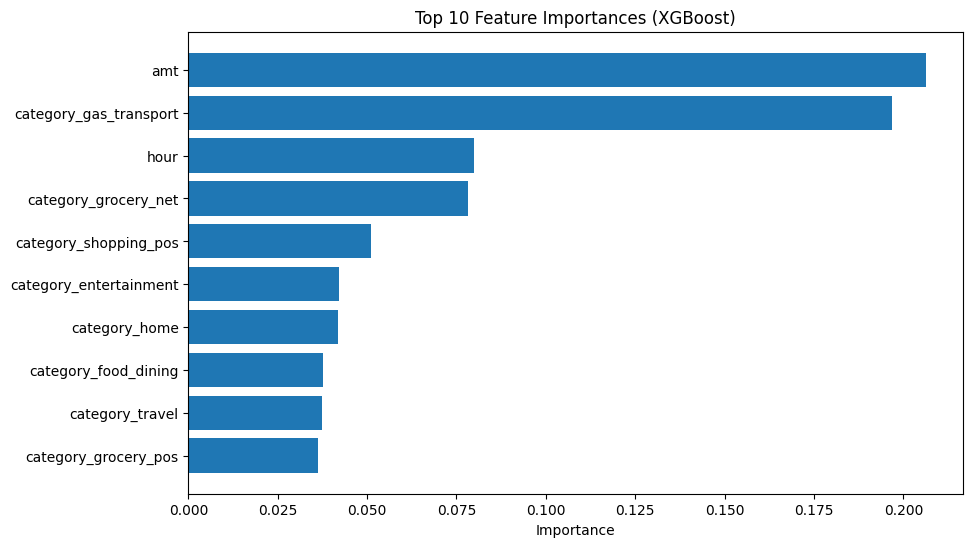

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

if hasattr(xgb_model, 'get_booster'):
    feature_names = xgb_model.get_booster().feature_names
else:
    feature_names = None

if feature_names is None or len(feature_names) != len(xgb_model.feature_importances_):
    feature_names = [f"Feature_{i}" for i in range(len(xgb_model.feature_importances_))]
    if len(X_train.columns) == 23:

        feature_names = X_train.columns.tolist()

importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importances)

plt.figure(figsize=(10, 6))
plt.barh(importances['Feature'][:10], importances['Importance'][:10])
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.show()

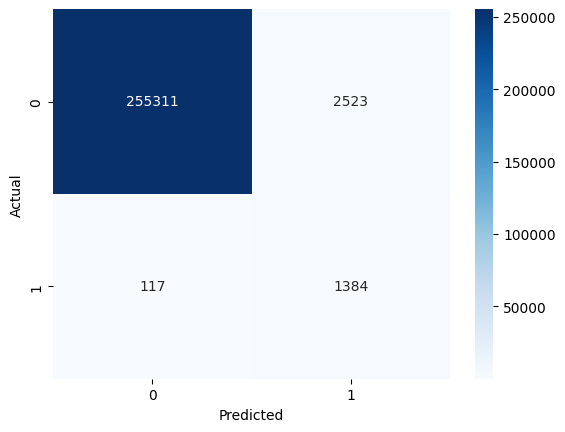

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_val, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
import joblib

joblib.dump(xgb_pipe, "fraud_xgb_pipeline.pkl")
joblib.dump(svm_pipe, "fraud_svm_pipeline.pkl")

joblib.dump(merchant_risk, "merchant_risk_dict.pkl")
joblib.dump(job_risk, "job_risk_dict.pkl")

joblib.dump(X_train.columns.tolist(), "model_columns.pkl")

['model_columns.pkl']